<a href="https://colab.research.google.com/github/ekaterina-kozh/SQL_EX/blob/main/class_vn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Разработай класс внимания, который будет включать механизм внимания Богданова и 3 варианта механизма внимания Luong:
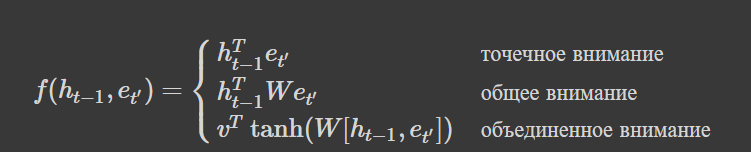

In [ ]:
import numpy as np
from random import randint
import unicodedata
import re
import pandas as pd
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Dense, Embedding, GRU, Input, Dense, Embedding, Bidirectional, Concatenate, Dropout, Dot
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras import utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Подготовка данных

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/LLM/dialogs.txt

--2024-10-06 13:06:53--  https://storage.yandexcloud.net/academy.ai/LLM/dialogs.txt
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243904 (238K) [text/plain]
Saving to: ‘dialogs.txt’

dialogs.txt         100%[===================>] 238.19K   390KB/s    in 0.6s    

2024-10-06 13:06:54 (390 KB/s) - ‘dialogs.txt’ saved [243904/243904]



Определние констант

In [ ]:
BATCH_SIZE = 128      # размер обучающего пакета.
EPOCHS = 60            # число эпох обучения.
UNITS  = 1024         # число нейронов в рекуррентных с слоях.
EMBED_DIM = 256       # размерность эмбеддинга.
NUM_SAMPLES = 3000   # число примеров для обучения.
FILE_NAME = "dialogs.txt" # имя файла со словарем в архиве
SOS = '<start>'       # токен начала последовательсти
EOS = '<end>'         # токен окончания последовательсти

Анализ датасета

In [ ]:
df = pd.read_csv(FILE_NAME, sep='\t', header=None)
df.head()

,0,1
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


In [ ]:
df[NUM_SAMPLES-5:NUM_SAMPLES]

,0,1
2995,so what's the problem?,i used all my savings on this one company.
2996,i used all my savings on this one company.,you put all your eggs into one basket.
2997,you put all your eggs into one basket.,"if the company goes out of business, i'll have..."
2998,"if the company goes out of business, i'll have...","oh, you'll have somethingyou'll have a lesson..."
2999,i was going to be a doctor.,what happened to your plans?


Подготовка данных

In [ ]:
def preprocess_sentence(w):
    w = re.sub(r"([?.!,;:¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    w = re.sub(r"[^a-zA-Zа-яёА-ЯЁ?'`.!,;:¿]+", " ", w)
    w = w.rstrip().strip()

    # Добавляем в фразу токены SOS и EOS
    w = SOS + ' ' + w + ' ' + EOS
    return w

Формирование выборок

In [ ]:
# Собираем вопросы и ответы в списки

questions = [] # список входных фраз
answers = []   # список ответных фраз

with open(FILE_NAME, "r", encoding="utf-8") as f: # открываем файл в режиме чтения
    lines = f.read().split("\n")                    # считываем весь файл, разделяя на строки

for line in lines[: min(NUM_SAMPLES, len(lines) - 1)]:
    input_text, target_text = line.split("\t")

    # Подготовка данных
    questions.append(preprocess_sentence(input_text))
    answers.append(preprocess_sentence(target_text))


print("Число примеров:", len(answers))

#  Получим случайный вопрос и ответ
random_index = randint(0, len(questions)-1)
print(f'Вопрос : {questions[random_index]}') # Пример входной фразы
print(f'Ответ : {answers[random_index]}')    # Пример ответной фразы

Число примеров: 3000
Вопрос : <start> what do you mean ? <end>
Ответ : <start> while you're using the bathroom , i'll order some food . <end>


Токенизируем выборку

In [ ]:
def tokenize(text): # функция принимает текст на заданном языке
    # Создадим токенайзер
    tokenizer = Tokenizer(filters='')

    # Загружаем в токенизатор тексты для обработки и сборки словаря частотности
    tokenizer.fit_on_texts(text)

    # Векторизируем фразы
    seq = tokenizer.texts_to_sequences(text)

    # Делаем последовательности одной длины, заполняя нулями короткие фразы
    pseq = pad_sequences(seq, padding='post')

    # Возвращаем последовательность индексов и токенизатор
    return pseq, tokenizer

In [ ]:
paddedQuestions, tokenizer_qu = tokenize(questions)    # формируем вектор фикс длины для вопросов  и токенизатор для английского языка
paddedAnswers, tokenizer_an   = tokenize(answers)      # формируем вектор фикс длины для ответов  и токенизатор для русского языка

max_length_qu = paddedAnswers.shape[1]
max_length_an = paddedQuestions.shape[1]

Обучающая и проверочная выборки

In [ ]:
# Создание обучающей и проверочной выборок в соотношении 80/20
questions_train, questions_val, answers_train, answers_val = train_test_split(paddedQuestions, paddedAnswers, test_size=0.2)

In [ ]:
# Определим параметры
BUFFER_SIZE = len(questions_train)                     # случайно сэмплировать будем по всей длине обучающейся выборки
STEPS_PER_EPOCH = len(questions_train)//BATCH_SIZE     # количество шагов в одной эпохе
VOCAB_EN_SIZE = len(tokenizer_qu.word_index) + 1
VOCAB_RU_SIZE = len(tokenizer_an.word_index) + 1

# Маппинг данных из индексов в слова
def convert(lang, tensor):
  for t in tensor:
    if t != 0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

print ("Исходный вопрос:")
convert(tokenizer_qu, questions_train[0])
print ()
print ("Целевой ответ:")
convert(tokenizer_an, answers_train[0])

Исходный вопрос:
1 ----> <start>
402 ----> remember
9 ----> to
212 ----> put
473 ----> air
22 ----> in
44 ----> your
408 ----> tires
3 ----> .
2 ----> <end>

Целевой ответ:
1 ----> <start>
43 ----> how
862 ----> often
13 ----> do
4 ----> i
18 ----> have
9 ----> to
13 ----> do
12 ----> that
5 ----> ?
2 ----> <end>


Создадим датасет tf.data.Dataset из массивов Numpy со случайной подачей тренировочных сэмплов в процессе обучения:

In [ ]:
# Создаём датасет
dataset = tf.data.Dataset.from_tensor_slices((questions_train, answers_train)).shuffle(BUFFER_SIZE)

# Передаем в датасет размер батча и указываем, что если в тренировке последний батч окажется неполным, то опустим его
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

# Посмотрим на форму примеров полученных батчей
example_questions_batch, example_answers_batch = next(iter(dataset))
print('Форма батчей вопросов и ответом: ', example_questions_batch.shape, example_answers_batch.shape)

Форма батчей вопросов и ответом:  (128, 24) (128, 24)


Архитектура сети

In [ ]:
class Encoder(tf.keras.Model):

  # Конструктор класса
  def __init__(self,
               vocab_size,    # размер словаря
               embedding_dim, # размер пространства эмбеддинга
               enc_units,     # число нейронов в GRU
               batch_sz):     # размер батча

    super(Encoder, self).__init__()                                   # вызываем инициализацию родительского класса
    self.batch_sz = batch_sz                                          # инициализируем переменную размера батча внутри класса
    self.enc_units = enc_units                                        # инициализируем переменную размера слоя в кодировщике
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)             # инициализируем слой эмбеддинга с заданными параметрами

    self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform') # инициализируем рекуррентный слой с заданными параметрами

  # Метод принимает входную фразу и начальное состояние
  def call(self,
           x,         # входная фраза
           hidden):   # начальное состояние

    x = self.embedding(x)   # входящие тензоры преобразовываются эмбеддингом
    output, state = self.gru(x, initial_state = hidden) # далее пропускаем через слой GRU и получаем выходные данные и новое состояние

    # Получаем форму output: (batch size, max_length, hidden_size)
    # Получаем форму state: (batch size, hidden_size)
    # sequence length == max_length
    # units == hidden_size
    return output, state # выход сети и состояние на выходе

  # Создаем метод инициализации состояний на скрытых слоях
  # Вернем тензор из нулей размер батча на размер слоя, его будем использовать как начальное состояние энкодера
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

# Создадим модель кодировщика по заданным параметрам
encoder = Encoder(VOCAB_EN_SIZE, EMBED_DIM, UNITS, BATCH_SIZE)

Механизм внимания

Механизма внимания Luong и 3 функции:

$$
f(h_{t-1}, e_{t'}) =
\begin{cases}
h_{t-1}^T e_{t'} & \text{точечное внимание}\\
h_{t-1}^T W e_{t'} & \text{общее внимание}\\
v^T \tanh \left(W [h_{t-1}, e_{t'}]\right) & \text{объединенное внимание}\\
\end{cases}
$$


Класс внимания, который будет включать механизм внимания Богданова и 3 варианта механизма внимания Luong. Выбор используемого механизма внимания должен происходить при инициализации класса.

In [ ]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, units, attention_type='bahdanau'):
        super(Attention, self).__init__()
        self.units = units
        self.attention_type = attention_type

        if attention_type == 'bahdanau':
            self.W1 = tf.keras.layers.Dense(units)
            self.W2 = tf.keras.layers.Dense(units)
            self.V = tf.keras.layers.Dense(1)
        elif attention_type in ['luong_dot', 'luong_general', 'luong_concat']:
            if attention_type == 'luong_general':
                self.Wa = tf.keras.layers.Dense(units)
            elif attention_type == 'luong_concat':
                self.Wa = tf.keras.layers.Dense(units)
                self.Va = tf.keras.layers.Dense(1)

    def call(self, query, values):
        if self.attention_type == 'bahdanau':
            # Bahdanau attention
            query_with_time_axis = tf.expand_dims(query, 1)
            score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
            attention_weights = tf.nn.softmax(score, axis=1)
            context_vector = attention_weights * values
            context_vector = tf.reduce_sum(context_vector, axis=1)
            return context_vector, attention_weights

        elif self.attention_type == 'luong_dot':
            # Luong dot attention
            score = tf.matmul(query, values, transpose_b=True)
            attention_weights = tf.nn.softmax(score, axis=-1)
            context_vector = tf.matmul(attention_weights, values)
            return context_vector, attention_weights

        elif self.attention_type == 'luong_general':
            # Luong general attention
            score = tf.matmul(query, self.Wa(values), transpose_b=True)
            attention_weights = tf.nn.softmax(score, axis=-1)
            context_vector = tf.matmul(attention_weights, values)
            return context_vector, attention_weights

        elif self.attention_type == 'luong_concat':
            # Luong concat attention
            query_with_time_axis = tf.expand_dims(query, 1)
            score = self.Va(tf.nn.tanh(self.Wa(tf.concat([query_with_time_axis, values], axis=-1))))
            attention_weights = tf.nn.softmax(score, axis=1)
            context_vector = attention_weights * values
            context_vector = tf.reduce_sum(context_vector, axis=1)
            return context_vector, attention_weights


In [ ]:
attention_layer = Attention(units=10, attention_type='bahdanau')

Декодировщик

In [ ]:
class Decoder(Model):

  # Конструктор класса
  def __init__(self,
               vocab_size,    # размер словаря
               embedding_dim, # размерность пространства эмбеддинга
               dec_units,     # число нейронов в GRU
               batch_sz):     # размер батча
    super(Decoder, self).__init__()                       # вызываем инициализацию родительского класса
    self.batch_sz = batch_sz                              # инициализируем переменную размера батча внутри класса
    self.dec_units = dec_units                            # инициализируем переменную размера слоя в декодировщике
    self.embedding = Embedding(vocab_size, embedding_dim) # инициализируем слой эмбеддинга с заданными параметрами

    self.gru = GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform') # инициализируем рекуррентный слой с заданными параметрами


    self.fc = Dense(vocab_size) # полносвязный слой с размером словаря

    self.attention = Attention(self.dec_units, attention_type='bahdanau') # механизм внимания


  def call(self,
           x,           # начальный токен входной последовательности
           hidden,      # состояние кодировщика
           enc_output # выход кодировщика
          ):

    context_vector, attention_weights = self.attention(hidden, enc_output)

    # Форма x после прохождения через  embedding: (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # Дальше конкатенируем с вектором контекста и получаем (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # Сконкатенированный вектор передаем  в GRU и получаем выход с декодера и состояние
    output, state = self.gru(x, initial_state = hidden)

    # Форма output: (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # Пропускаем через полносвязный слой
    x = self.fc(output)

    # Форма выходной фразы: (batch_size, vocab)
    # Вернем выходную фразу, вектор состояния, веса внимания
    return x, state, attention_weights

In [ ]:
# Создали декодировщик с параметрами
decoder = Decoder(VOCAB_RU_SIZE, EMBED_DIM, UNITS, BATCH_SIZE)

Оптимизатор и функция потерь

In [ ]:
# Оптимизатор Adam
optimizer = tf.keras.optimizers.Adam()

# Функция потерь
def loss_function(real, pred):

  # Не все последовательности имеют одинаковую длину.
  # Если в последовательности есть "0", то соответствующую ей потерю будем обнулять
  # Для этого создадим маску
  mask = tf.math.logical_not(tf.math.equal(real, 0))

  # Создаем экземпляр класса SparseCategoricalCrossentropy
  # И сразу вызываем его метод call() с параметрами: истинная и предсказанная фраза
  # Получаем тензор ошибки
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(real, pred)

  mask = tf.cast(mask, dtype=loss.dtype) # приводим тип маски к типу потерь
  loss *= mask                           # маскируем потери, избавляемся от заполняющих нулей

  return tf.reduce_mean(loss) # вернем среднее значение тензора

Обучение модели

In [ ]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden): # определим входную фразу, перевод и состояние кодировщика
  loss = 0 # переменная для фиксации ошибки

  # tf.GradientTape() - записывает все  операции по вычислению градиента на ленту (tape)
  with tf.GradientTape() as tape:

    # Передаем входную последовательность и начальное состояние кодировщика
    # Получим выход и состояние на выходе
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    # dec_hidden используется вниманием, передадим состояние enc_hidden в декодер (фактически переименование для сохранения сути)
    dec_hidden = enc_hidden

    # SOS <start> токен инициализирует вход декодировщика
    dec_input = tf.expand_dims([tokenizer_ru.word_index[SOS]] * BATCH_SIZE, 1)

    # teacher forcing technique - ввод целевого токена (выходного слова) в качестве следующего входного токена
    for t in range(1, targ.shape[1]): # для каждого слова из фразы

      # Передаем enc_output в декодировщик
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      # Вычисляем потери
      loss += loss_function(targ[:, t], predictions)

      # Используем teacher forcing (переход на следующий шаг)
      dec_input = tf.expand_dims(targ[:, t], 1)

  # Поскольку эта функция вызывается для каждого пакета, вычисляем значение batch_loss
  batch_loss = (loss / int(targ.shape[1]))

  # Получаем переменные модели, для которых нужно считать градиенты
  variables = encoder.trainable_variables + decoder.trainable_variables

  # Вычисляем градиенты
  gradients = tape.gradient(loss, variables)

  # Обновляем веса модели
  optimizer.apply_gradients(zip(gradients, variables))

  # Функция обучения возвращает значение ошибки на батче
  return batch_loss

In [ ]:
import time

# Цикл обучения
for epoch in range(EPOCHS):
  start = time.time()

  # Инициализация скрытого состояния
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  # Цикл по всему датасету
  for (batch, (inp, targ)) in enumerate(dataset.take(STEPS_PER_EPOCH)):

    # Вызываем метод обучения
    batch_loss = train_step(inp, targ, enc_hidden)

    # Вычисляем потери по пакетам
    total_loss += batch_loss

  # Сохраняем чекпоинты каждые 5 эпох
  if (epoch + 1) % 5 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  # статистика по каждой эпохе
  print(f'Эпоха: {epoch + 1}  |  Потеря:  {(total_loss / STEPS_PER_EPOCH):.4f}  |  Время на эпоху: {time.time() - start} сек \n' )

Эпоха: 1  |  Потеря:  2.1904  |  Время на эпоху: 55.41037106513977 сек 

Эпоха: 2  |  Потеря:  1.8187  |  Время на эпоху: 22.759917736053467 сек 

Эпоха: 3  |  Потеря:  1.7108  |  Время на эпоху: 22.678081035614014 сек 

Эпоха: 4  |  Потеря:  1.6168  |  Время на эпоху: 21.696540355682373 сек 

Эпоха: 5  |  Потеря:  1.5264  |  Время на эпоху: 23.056357860565186 сек 

Эпоха: 6  |  Потеря:  1.4399  |  Время на эпоху: 21.886414766311646 сек 

Эпоха: 7  |  Потеря:  1.3605  |  Время на эпоху: 22.156334161758423 сек 

Эпоха: 8  |  Потеря:  1.2837  |  Время на эпоху: 22.29591703414917 сек 

Эпоха: 9  |  Потеря:  1.2041  |  Время на эпоху: 22.64657974243164 сек 

Эпоха: 10  |  Потеря:  1.1275  |  Время на эпоху: 22.809507369995117 сек 

Эпоха: 11  |  Потеря:  1.0480  |  Время на эпоху: 22.725332975387573 сек 

Эпоха: 12  |  Потеря:  0.9662  |  Время на эпоху: 22.945930004119873 сек 

Эпоха: 13  |  Потеря:  0.8851  |  Время на эпоху: 22.467544078826904 сек 

Эпоха: 14  |  Потеря:  0.8052  |  Вре

Тестирование модели

In [ ]:
import numpy as np

# Функция оценки - аналогична циклу обучения
def evaluate(sentence):

  # График внимания (будет построен позже)
  attention_plot = np.zeros((max_length_ru, max_length_en))

  sentence = preprocess_sentence(sentence)

  # Приведем предложение к нижнему регистру и разобьем на слова
  words = sentence.split(' ')
  inputs = list() # список для сбора токенов

  # Для каждого слова в предложении найдем токен в словаре, если не найдем, то пропустим
  for word in words:

      try:
          inputs.append(tokenizer_en.word_index[word]) # находим индекс в словаре и добавляем в список
      except:
          pass # игнорируем слово, которое не знаем

  # Зафиксируем длину последовательности, дополнив нулями
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_en,
                                                         padding='post')
  # Конвертируем вход в тензор
  inputs = tf.convert_to_tensor(inputs)
  print(inputs)
  result = ''

  hidden = [tf.zeros((1, UNITS))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([tokenizer_ru.word_index[SOS]], 0)

  # Повторяйте цикл до тех пор, пока не будет достигнута максимальная длина для целевого языка
  for t in range(max_length_ru):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # Сохраняем значения коэффициентов внимания
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    # Получаем предсказание с максимальным вниманием
    predicted_id = tf.argmax(predictions[0]).numpy()

    # Добавляем токены к результату
    result += tokenizer_ru.index_word[predicted_id] + ' '

    # Если токен <end> достигнут, возвращаем результат, входные данные и график внимания
    if tokenizer_ru.index_word[predicted_id] == EOS:
      return result, sentence, attention_plot

    # Педсказанное значение подается обратно в модель
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Функция отображения коэффициентов внимания
# attention - веса внимания
# sentence - исходная фраза
# predicted_sentence - предсказаный перевод

def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis') # рисуем 2d матрицу
  fontdict = {'fontsize': 14}           # размер текста

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90) # подписи по горизонтали
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)    # подписи по вертикали

  # Задаем форматирование делений (тикеров) по осям
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
# Функция ответа на вопрос
def answer(sentence):
  # Вызов функции evaluate()
  result, sentence, attention_plot = evaluate(sentence)

  print('Ввод: %s' % (sentence))
  print(f'Перевод: {result}')

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
# Restore the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Генерируем ответы

tf.Tensor(
[[  1   6 626   4   2   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]], shape=(1, 24), dtype=int32)
Ввод: <start> Are you hungry ? <end>
Перевод: yet know . <end> 


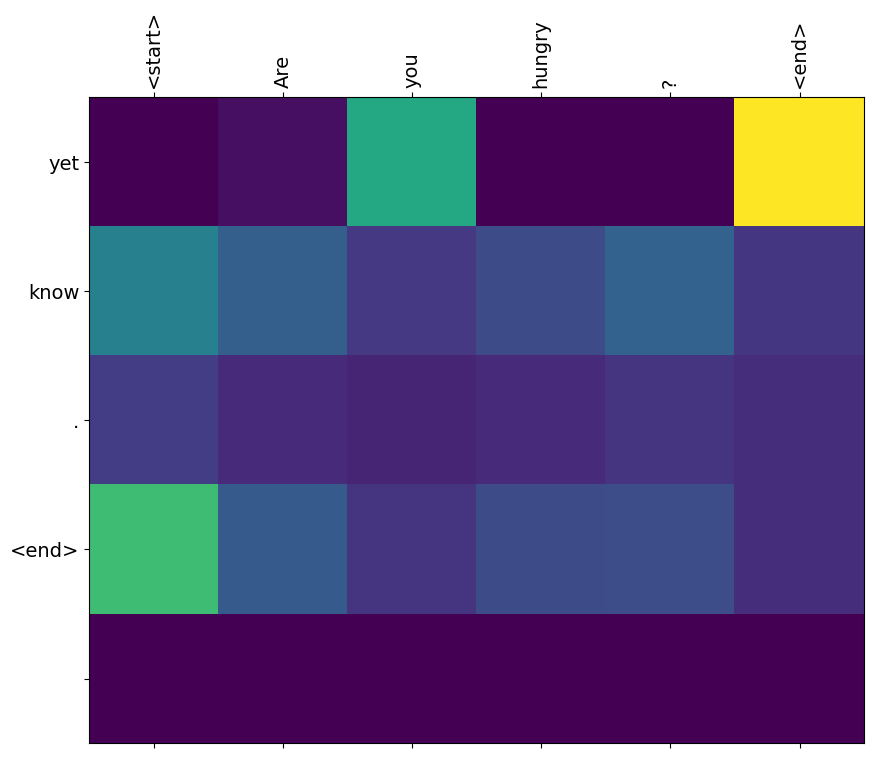

In [ ]:
answer('Are you hungry?')

tf.Tensor(
[[  1 515   8  29  22   6 117   4   2   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]], shape=(1, 24), dtype=int32)
Ввод: <start> hi , how are you doing ? <end>
Перевод: did , i happy . not you <end> 


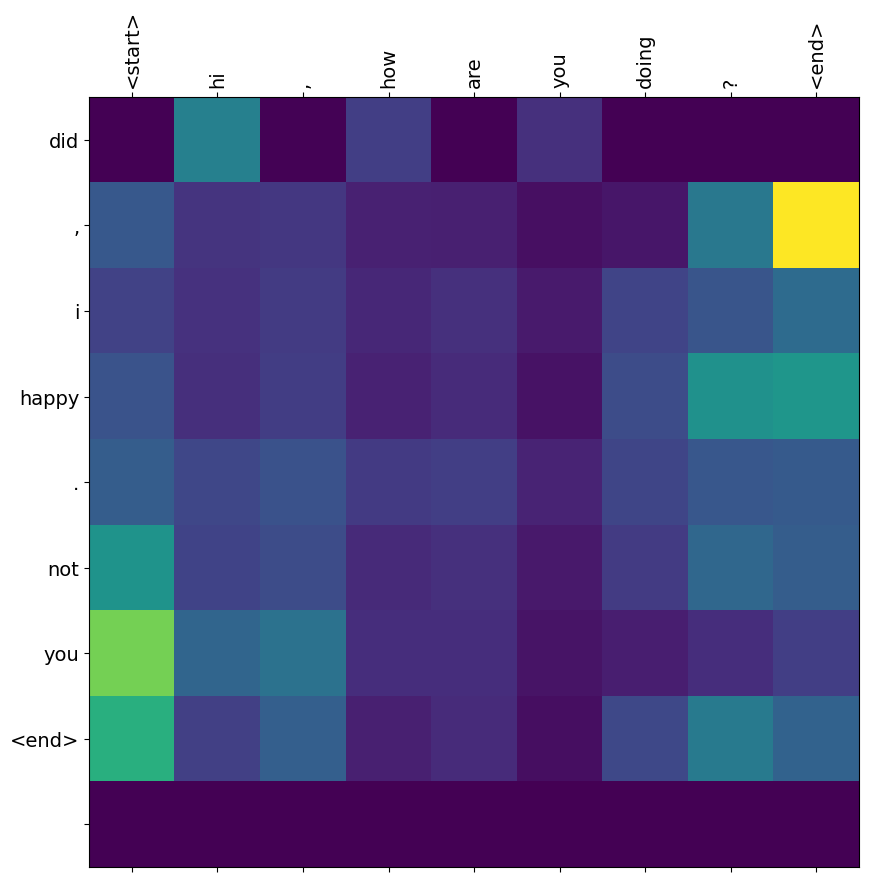

In [ ]:
answer('hi, how are you doing?')

tf.Tensor(
[[  1   5 204 387   3  29  23 388   4   2   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]], shape=(1, 24), dtype=int32)
Ввод: <start> i am fine . how about yourself ? <end>
Перевод: other like talk . did , be but will . <end> 


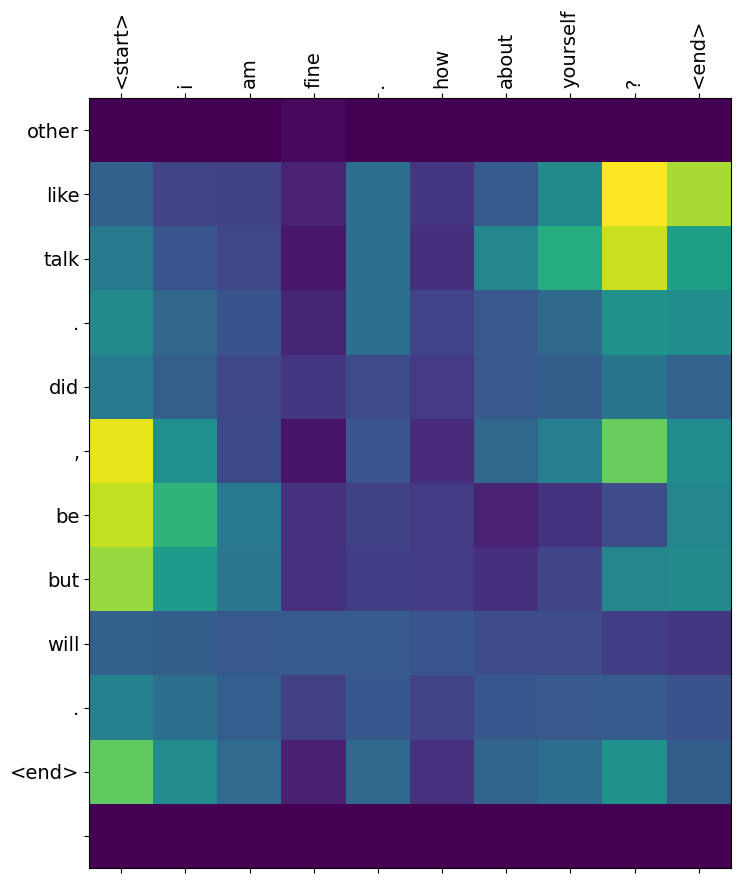

In [ ]:
answer('i am fine. how about yourself?')

Результат не такой хороший, какой мы ожидали. Для более лучшего резульата нужно увеличить кол-во примеров для обучения и эпох.